In [ ]:
# #드라이브 마운트
# from google.colab import drive
# drive.mount('/content/drive')

# #현재 작업 위치 이동
# #띄어쓰기에 \붙일 것
# %cd /content/drive/Othercomputers/내\ 노트북/Devpy_work/02.멀티캠퍼스

# 전이학습

* 작은 이미지 데이터셋에 딥러닝을 적용하는 일반적이고 매우 효과적인 방법은 **사전 훈련된 네트워크**를 사용하는 것입니다. 
* 사전 훈련된 네트워크는 대규모 이미지 분류 문제를 위해 대량의 데이터셋에서 미리 훈련되어 저장된 네트워크입니다.

[ImageNet]https://image-net.org/update-mar-11-2021.php
* ImageNet 데이터셋(1.4백만 개의 레이블된 이미지와 1,000개의 클래스로 이루어진) 에서 훈련된 대규모 컨브넷을 사용해 보겠습니다. 
* ImageNet 데이터셋은 다양한 종의 강아지와 고양이를 포함해 많은 동물들을 포함하고 있습니다. 
* 강아지 vs. 고양이 분류 문제에 좋은 성능을 낼 것 같습니다.


[VGG16]
* ImageNet 데이터셋에 널리 사용되는 컨브넷 구조입니다. 
* VGG16은 조금 오래되었고 최고 수준의 성능은 아니지만 구조이해해 도움이 됩니다. 
* VGG16 모델은 케라스에 패키지로 포함되어 있습니다.
* 이후에 VGG, ResNet, Inception, Inception-ResNet, Xception 등 더 최신의 사전훈련모델을 사용해 보세요.


[사용방법]
* 특성 추출과 미세 조정

## 특성 추출

* 사전에 학습된 네트워크의 표현을 사용해 새로운 샘플에서 흥미로운 특성을 뽑아내는 것입니다. 
* 사전에 학습된 네트워크에서 합성곱 층만 재사용하고, 완전연결층은 문제에 맞게 새로운 분류기를 만들어 훈련합니다. 

**왜 합성곱 층만 재사용할까요? 완전 연결 분류기도 재사용할 수 있을까요?**
* 일반적으로 권장하지 않습니다. 합성곱 층에 의해 학습된 표현이 더 일반적이어서 재사용 가능하기 때문입니다. 
* 컨브넷의 특성 맵은 사진에 대한 일반적인 컨셉의 존재 여부를 기록한 맵입니다. 
* 그래서 주어진 컴퓨터 비전 문제에 상관없이 유용하게 사용할 수 있습니다. 
* 하지만 분류기에서 학습한 표현은 모델이 훈련된 클래스 집합에 특화되어 있습니다. 


[참고]
* 특정 합성곱 층에서 추출한 표현의 일반성(그리고 재사용성)의 수준은 
* 모델의 하위 층은 (에지, 색깔, 질감 등과 같이) 지역적이고 매우 일반적인 특성 맵을 추출합니다. 
* 상위 층은 ('강아지 눈'이나 '고양이 귀'와 같이) 좀 더 추상적인 개념을 추출합니다.

---

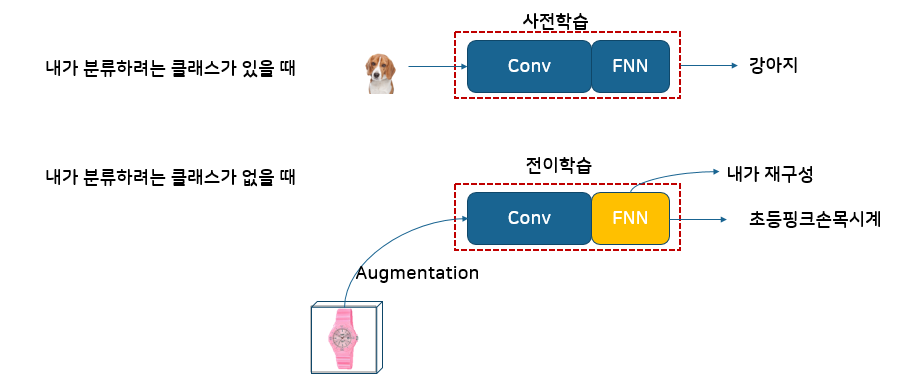

## 사전 훈련 된 모델 구성하기

https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16

In [1]:
from tensorflow.keras.applications.vgg16 import VGG16

In [2]:
conv_base = VGG16(weights='imagenet' , # 초기화한 가중치 종류
            include_top = False, #FNN층 사용하지 않고 내가 재구성할 것임
            input_shape = (150,150,3)) 

In [3]:
conv_base.trainable = False # 컨브넷 동결, 훈련이 적용되지 않음

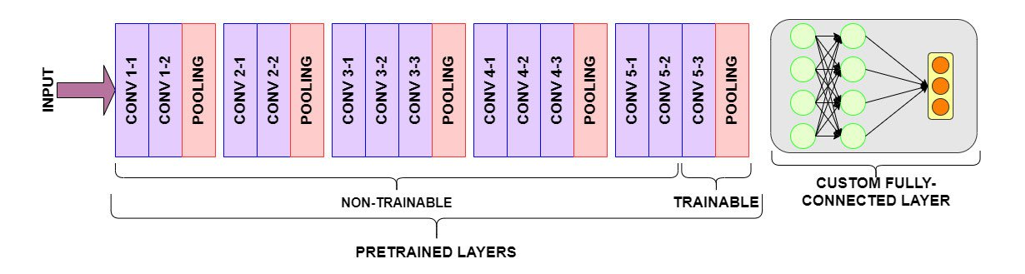

In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

* 최종 특성 맵의 크기는 `(4, 4, 512)`입니다. 
* 이 특성 위에 완전 연결 층을 놓을 것입니다.
* 준비한 모델(`conv_base`) 위에 `Dense` 층을 쌓아 확장합니다. 
* 그다음 입력 데이터에서 엔드 투 엔드로 전체 모델을 실행합니다. 
* 모델에 노출된 모든 입력 이미지가 매번 합성곱 기반층을 통과하기 때문에 데이터 증강도 함께 사용할 수 있습니다.

## 딥러닝 구성하기

* Convolution 층은 VGG16인 pretrained 모델을 가져다가 사용하고
* FNN(Full connected Layer)는 목적에 맞게 층을 구성해서 사용합니다. 
* 여기서 우리의 목적은 개와 고양이 분류하는 것이 목적이므로
* 이진분류가 될 수 있도록 모델을 구성해야 합니다. 

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout

model = Sequential()

# 사전학습모델 추가
model.add(conv_base)

#FNN층 구성

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # 개 또는 고양이 분류 목적, 이진 분류

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________


* VGG16의 합성곱 기반층은 14,714,688개의 매우 많은 파라미터를 가지고 있습니다.
* 합성곱 기반층 위에 추가한 분류기는 4백만 개의 파라미터를 가집니다.

## 데이터 증강

In [ ]:
# #드라이브 마운트
# from google.colab import drive
# drive.mount('/content/drive')

# #현재 작업 위치 이동
# #띄어쓰기에 \붙일 것
# %cd /content/drive/Othercomputers/내\ 노트북/Devpy_work/02.멀티캠퍼스

In [7]:
## 이미 사용할 데이터 구분 다 해놨을 때.
## 디렉토리 경로 정보만 필요할 때 사용

import os, shutil

# 원본 데이터셋을 압축 해제한 디렉터리 경로
# original_dataset_dir = './dataset/cats_and_dogs/train'

# 소규모 데이터셋을 저장할 디렉터리
base_dir = './data/cats_and_dogs_small'

# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = os.path.join(base_dir, 'train')

validation_dir = os.path.join(base_dir, 'validation')

test_dir = os.path.join(base_dir, 'test')

In [8]:
train_dir

'./data/cats_and_dogs_small\\train'

In [9]:
from keras.preprocessing.image import ImageDataGenerator
#훈련용 제너레이터
train_datagen = ImageDataGenerator(
                rescale=1./255,    #전처리
                rotation_range=40, # 랜덤하게 사진을 회전시킬 각도 범위(0~180)
                width_shift_range=0.2, #사진을 수평과 수직으로 랜덤하게 평행 이동시킬 범위
                height_shift_range=0.2,
                shear_range=0.2, #랜덤하게 전단 변환을 적용할 각도 범위
                zoom_range=0.2,   #랜덤하게 사진을 확대할 범위
                horizontal_flip=True, #랜덤하게 이미지를 수평으로 뒤집기
                fill_mode='nearest') #회전이나 가로/세로 이동으로 인해 새롭게 생성해야 할 픽셀을 채울 전략
# 검증용 데이터는 augmentation 적용하지 않음
valid_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator =  train_datagen.flow_from_directory(
                    train_dir, #타깃 디렉토리
                    target_size=(150,150), #모든 이미지의 크기를 150x150로 변경
                    batch_size=20, #하드 드라이브에서 몇 장의 이미지를 메모리에 올릴껀지(훈련용으로)
                    class_mode='binary' #이진분류의 목적이므로 자동으로 train_dir아래에 두가지의 폴더를 기준으로 라벨링처리
                )

Found 2000 images belonging to 2 classes.


In [11]:
valid_generator =  valid_datagen.flow_from_directory(
                    validation_dir, #검증 디렉토리
                    target_size=(150,150),
                    batch_size=20,
                    class_mode='binary'
                )

Found 1000 images belonging to 2 classes.


In [12]:
from sklearn import metrics


model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [13]:
epoch_hist = model.fit_generator(
                  train_generator,
                  steps_per_epoch=100,
                  epochs=30,
                  validation_data = valid_generator,
                  validation_steps=50,
                  verbose=1
)

C:\Users\lullu\AppData\Local\Temp\ipykernel_2688\2020541672.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  epoch_hist = model.fit_generator(


Epoch 1/30


결과 그래프를 다시 그려 봅시다:

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc, label='Training acc')
plt.plot(val_acc,label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(loss, label='Training loss')
plt.plot(val_loss,label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 정리

* VGG16은 Pretrained(사전학습 된) 모델이라고 합니다.
* Imagenet(1000개의 클래스 학습)을 기반으로 훈련한 모델로 높은 자원과 기술을 바탕으로 만들었기 때문에
* 우리가 이만큼의 훈련데이터를 수집하고 훈련시키기 까지 많은 자원과 기술이 필요합니다. 
* 아주 작은 데이터셋에서도 빠르게 목적에 맞는 모델을 만들 수 있는데 이때 Pretrained Model을 활용합니다. 
* 이미 훈련이 다 되어있기 때문에 처음부터 훈련해서도 괜찮은 성능을 낼 수 있습니다.
* 그런데 우리가 수집한 이미지 데이터는 작은 데이터셋이고, 과대적합이 큰 문제입니다. 
* 이때 데이터 증식(Data Augmentation)은 이미지 데이터를 다룰 때 과대적합을 막을 수 있는 강력한 방법입니다.
* 특성 추출 방식으로 새로운 데이터셋에 기존의 컨브넷을 쉽게 재사용할 수 있습니다. 작은 이미지 데이터셋으로 작업할 때 효과적인 기법입니다.


---

## 평가하기

## 일반 고양이와 강아지

## 이상한 고양이와 강아지
* 일반적인 이미지 이외에 왜곡된 이미지도 잘 분류할 수 있는지 여부 확인


## 고양이상 VS 강아지상